In [117]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import os
import pandas as pd
import scipy.stats
import seaborn as sns
from tqdm import tqdm
tqdm.pandas(desc='My bar!')

Populating the interactive namespace from numpy and matplotlib


/cm/shared/apps/spack/gpu/opt/spack/linux-centos8-skylake_avx512/gcc-8.3.1/anaconda3-2020.11-bsn4npoxyw7jzz7fajncek3bvdoaa5wv/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [118]:
def longest_perfect_repeat(ref, motif):
    max_cnts = []
    
        
    strand_ref = ""
    for x in ref:
        if x == 'T':
            strand_ref += "A"
        if x == "A":
            strand_ref += "T"
        if x == "G":
            strand_ref += "C"
        if x == "C":
            strand_ref += "G"
    strand_ref = strand_ref[::-1]
    
    for ref_ in [ref, strand_ref]:
        for mot in [motif, motif[::-1]]:
                i = 0
                match = 0
                max_match = 0
        
                while True:
                    if i >= len(ref_):
                        break
                    for j in range(0,len(motif)):
                        k = i
                        while True:
                            while j < len(mot) and k < len(ref_) and ref_[k] == mot[j]:
                                k += 1
                                j += 1
                                match += 1
                            max_match = max(max_match, match)
                            if j == len(motif):
                                j = 0
                                i = k
                            else:
                                if j == len(motif) - 1:
                                    i += 1
                                match = 0
                                break

                        j = 0
                max_cnts.append(max_match)

    return max(max_cnts)

longest_perfect_repeat('TGAAGAAAAAGAAAAAGAAATAAAAG', 'AAAAAG')

18

In [113]:
PLOTDIR = "pdfs"

dfs = []
for chrom in range(1, 23):
    print(chrom)
    if not os.path.exists("chr%s.period.tab"%chrom): 
        continue
    data = pd.read_csv("chr%s.stats.tab"%chrom, sep="\t")
    data = data.drop_duplicates(subset = ['chrom', 'start'], keep = False)
    motifs = pd.read_csv(f"methods_{chrom}.txt", 
                         sep="\t", names=["chrom", "start", "ref", "period", "motif", "method"])
    motifs = motifs.drop_duplicates(subset = ['chrom', 'start'], keep = False)
    motifs = motifs[motifs['period'] != 1]
    data = pd.merge(data, motifs, on=["chrom","start"])
    data["reflen"] = data['ref'].str.len() / data['motif'].str.len()
    data["reflen-bp"] = data['ref'].str.len()
    data = data[(data["motif"].apply(type)==str)]
    data['longest_repeat_stretch'] = data.apply(lambda x: longest_perfect_repeat(x['ref'], x['motif']), axis = 1)
    dfs.append(data)

data = pd.concat(dfs)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [25]:
LABSIZE = 18
TICKSIZE = 14

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    
def PlotLenVsHet(data, ax=None, lencol="reflen", lineskip=1, pop=None, motifs=None, colors=None,
                 figname=None, methods=None):
    """
    Plot length vs. het
    If pop=None, use het-ALL. else use het-${pop}
    motifs is a list of motifs. or 1, 2, 3 etc. for
    all motifs with that length. Use "vntr" for 7+
    """
    
        
    
    
    if lencol == "reflen":
        MINLEN = 10
        MAXLEN = 30
    else:
        MINLEN = 10
        MAXLEN = 100
    if pop is None:
        col = "het-ALL"
    else: col = "het-%s"%pop
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches((8, 6))
        ax = fig.add_subplot(111)
    if motifs is None:
        motifs = ["ALL"]
        colors = ["black"]
        
    for k in range(len(methods)):
        method = methods[k]
        pdata = ""
        if method == "gangstr_only":
            pdata = data[data['method'] == "0|0|0|1"].copy()
        elif method == "hipstr_only":
            pdata = data[data['method'] == "0|0|1|0"].copy()
        elif method == "eh_only":
            pdata = data[data['method'] == "0|1|0|0"].copy()
        else:
            pdata = data.copy()
            
        for i in range(len(motifs)):
            m = motifs[i]
            lenbins = range(MINLEN, MAXLEN+1)
            if lencol == "reflen":
                lenbins = np.arange(MINLEN, MAXLEN, 1)
            else:
                if (m in [1,2,3] or (type(m)==str and len(m) <3)) and m != "vntr" and (m != "ALL"):
                    lenbins = range(MINLEN, MAXLEN+1)
                else:
                    lenbins = np.arange(MINLEN, MAXLEN, 1)  # could go lower resolution here if we want
            color = colors[i+k]
            xvals = []
            yvals = []
            for j in range(len(lenbins)-1):
                lb = lenbins[j]
                ub = lenbins[j+1]
                xx = pdata[(pdata[lencol]>=lb) & (pdata[lencol]<ub) &       
                           (pdata["motif"].apply(lambda x: GetMatchesMotif(x, [m]), 1))]
                if xx.shape[0] > 10:
                    xvals.append(lb)
                    yvals.append(np.mean(xx[col]))
            ax.plot(xvals, yvals, color=color, label=f"{m}-{method}")
    if lineskip is not None:
        for i in range(MINLEN, MAXLEN+1, lineskip):
            ax.axvline(x=i, linewidth=0.5, color="gray")
    if lencol == "lencol":
        ax.set_xlabel("Length", size=LABSIZE)
    else:
        ax.set_xlabel("Length (bp)", size=LABSIZE)
    ax.set_ylabel("Mean heterozygosity", size=LABSIZE)
    ax.legend(loc="lower right")
    if pop is not None: ax.set_title(pop)
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
    ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)
    #if figname is not None and ax is None: fig.savefig(figname)
        
# Plot reflen vs. het by period, overall and for each population

def GetMatchesMotif(motif, motiflist):
    for m in motiflist:
        if m == "ALL": return True
        elif type(m) == int or type(m) == float:
            if len(motif)==m: return True
        elif m == "vntr":
            if len(motif)> 6: return True
        else:
            if m == motif: return True
    return False
    

#     if figname is not None and ax is None: fig.savefig(figname)

colors = ["red","orange","blue","green","gold","purple","pink","brown","cyan","gray"]

1 1


<ipython-input-25-bf75542e5ad5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
<ipython-input-25-bf75542e5ad5>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)


2 0


<ipython-input-25-bf75542e5ad5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
<ipython-input-25-bf75542e5ad5>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)


0 1


<ipython-input-25-bf75542e5ad5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
<ipython-input-25-bf75542e5ad5>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)


1 0


<ipython-input-25-bf75542e5ad5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
<ipython-input-25-bf75542e5ad5>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)


2 1


<ipython-input-25-bf75542e5ad5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
<ipython-input-25-bf75542e5ad5>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%.1f"%item for item in ax.get_yticks()], size=TICKSIZE)


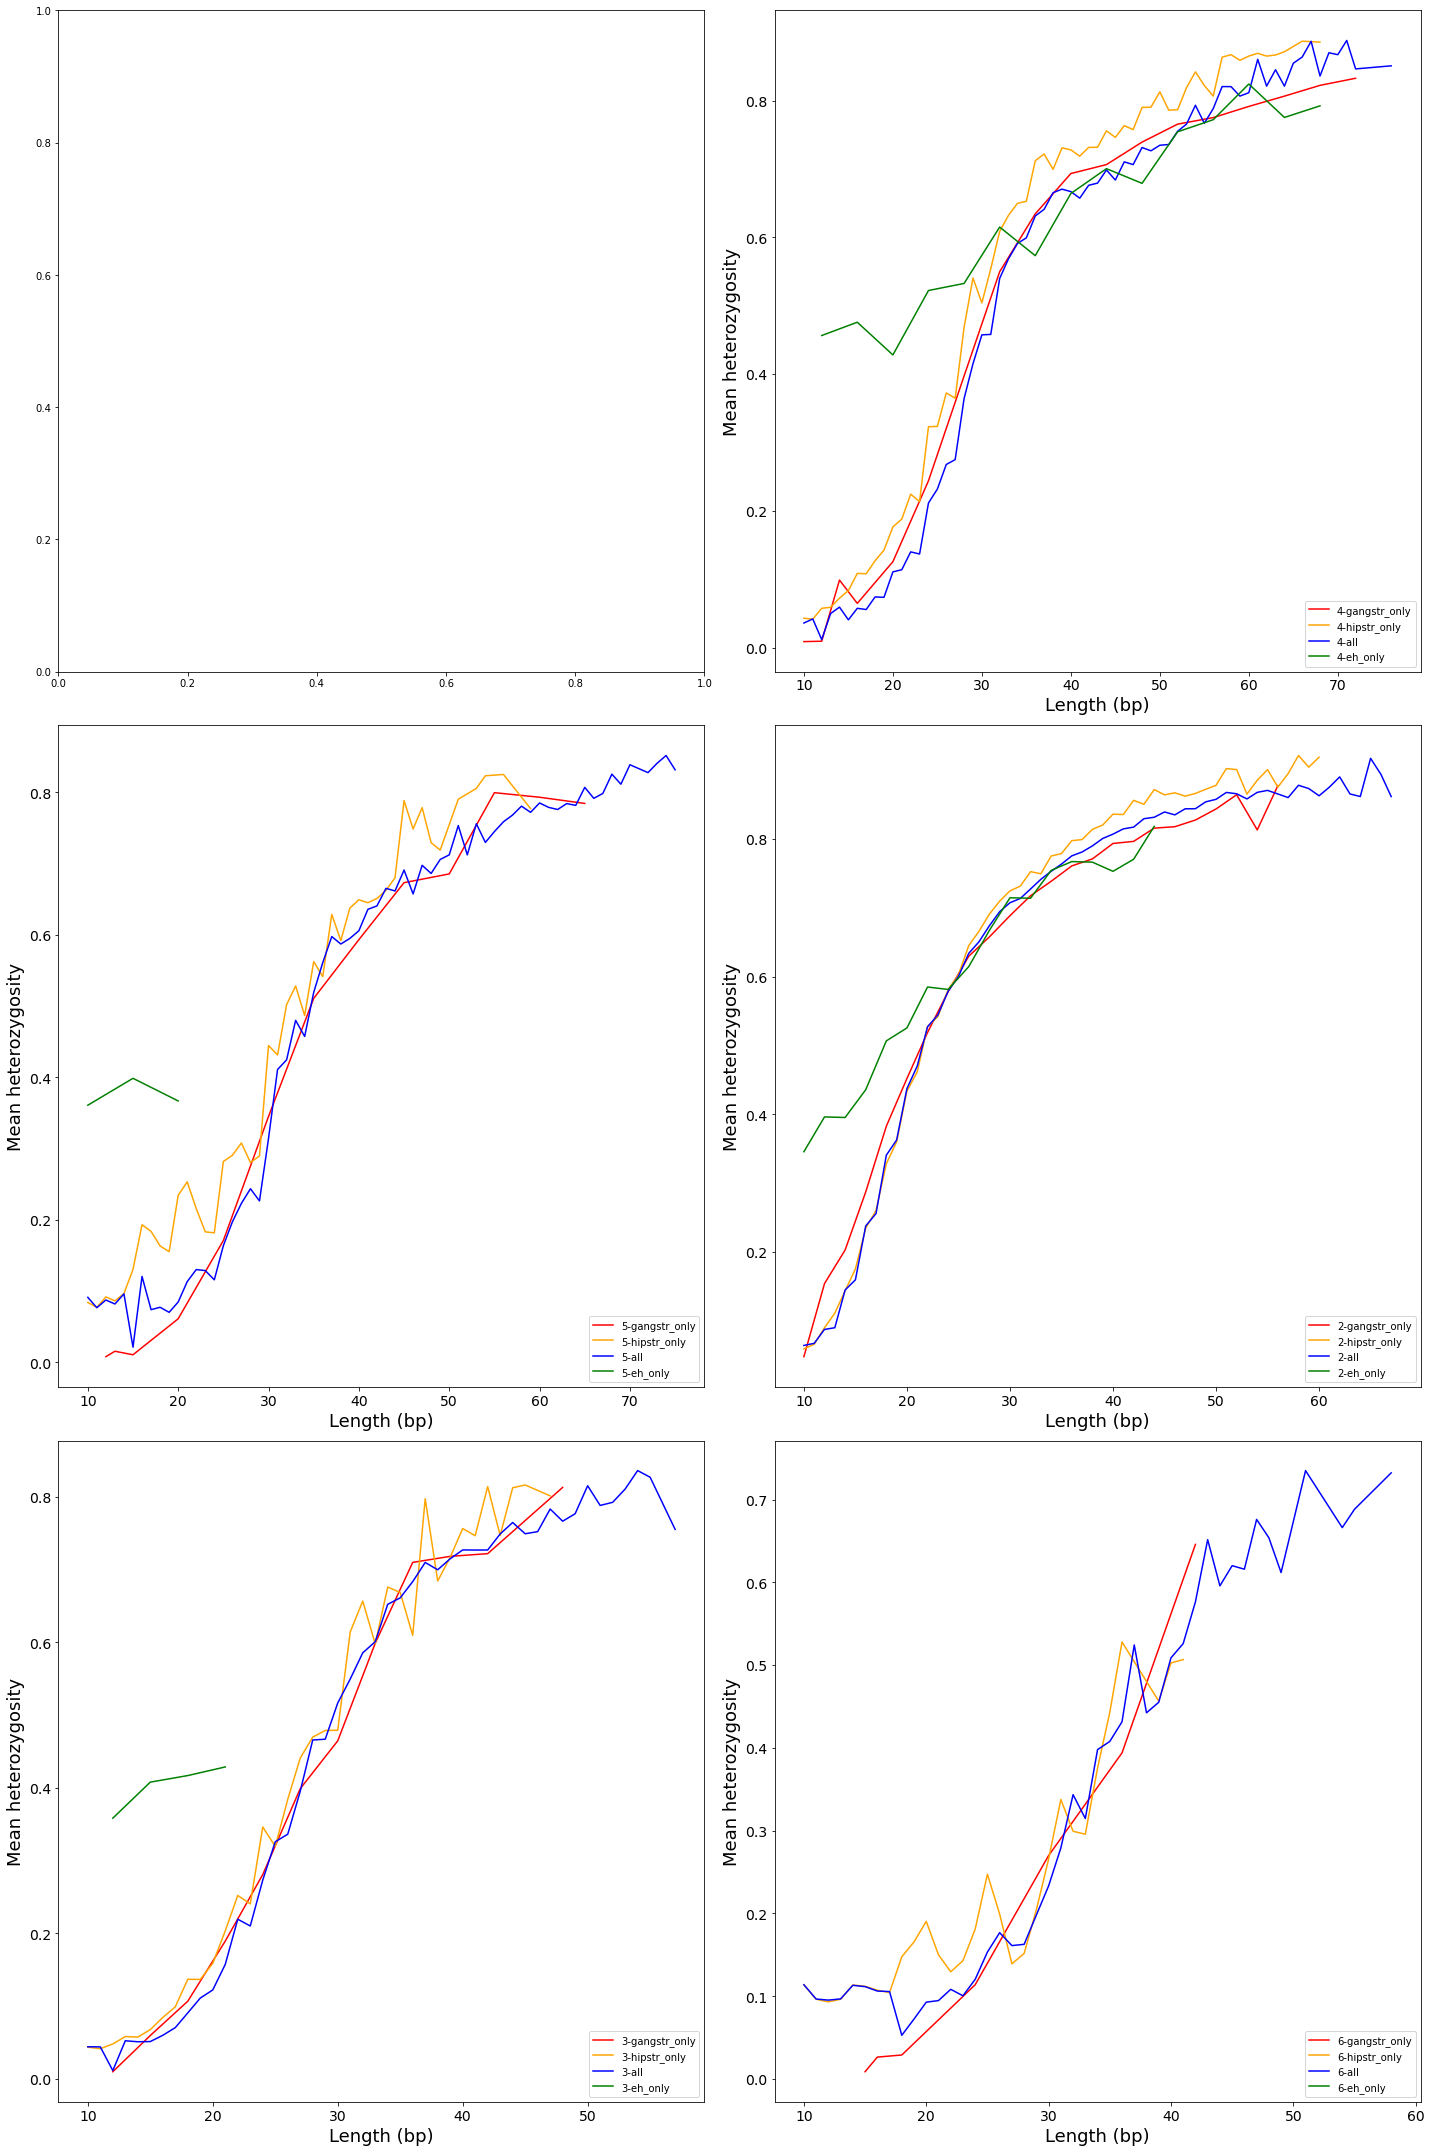

In [116]:

pltdata = data
fig, axs = plt.subplots(3, 2)
fig.set_size_inches((20, 30))
for i in range(2,7):
    print((i - 1) % 3, (i - 1) % 2)
    ax = axs[(i - 1) % 3, (i - 1) % 2]
    PlotLenVsHet(pltdata, ax=ax, motifs=[i], colors=colors, lineskip=None,
                 lencol="longest_repeat_stretch", methods=['gangstr_only', 'hipstr_only', 'all', 'eh_only']);
fig.tight_layout()
